In [1]:
from numpy import array
import time
import os
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


#Models

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight



#parallel
import joblib
from joblib import parallel_backend
from joblib import Parallel, delayed
import dask
from dask.distributed import Client, progress, LocalCluster, SSHCluster,wait
from scipy.spatial.distance import squareform
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from PyALE import ale
from dask import delayed

In [2]:
#import data

comb_dinuc_df= pd.read_csv('/shares/kslotkin_share/private/tratnayake/frNAnet/R_FG/train/S07161321_dinuc_df.txt',header=0,sep='\t')


np.shape(comb_dinuc_df)


shuf_comb_dinuc_df=comb_dinuc_df.iloc[np.random.permutation(len(comb_dinuc_df))]


#reset index
shuf_comb_dinuc_df=shuf_comb_dinuc_df.reset_index(drop=True)
#shuf_comb_dinuc_df


In [3]:
ydt=shuf_comb_dinuc_df['ptype']
#ydt


xdt=shuf_comb_dinuc_df.drop(['seq_id','ptype'],axis=1)
#xdt

In [4]:
######################### split data #####################################

#split test train data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(xdt, ydt, test_size=0.2, random_state=256)

#only if cross-validation is not used
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Xdt_train.shape, Xdt_test.shape
######################################################################################


((636865, 21), (159217, 21))

In [5]:
with parallel_backend('threading',n_jobs=48 ):


    #print('traing>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(ydt_train), y=ydt_train)
    class_weights

    rfc_dicomb = RandomForestClassifier(random_state=515,n_estimators = 200,class_weight=dict(enumerate(class_weights) ),n_jobs=48)


    #'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'log_loss', 'bootstrap': True

#    rfc_dicomb= RandomForestClassifier(
#        n_estimators=200,
#        criterion='log_loss',
#        max_depth=100,
#        min_samples_split=10,
#        min_samples_leaf=2,
#        max_features='log2',
#        bootstrap=True,
#        n_jobs=16,
#        random_state=0,
#        class_weight=dict(enumerate(class_weights))
#    )


    print('training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    #model train
    rfc_dicomb.fit(Xdt_train, ydt_train)


    # Predict the Test set results

    y_pred =  rfc_dicomb.predict(Xdt_test)

training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [6]:
print('Model test accuracy : {0:0.4f}'. format(accuracy_score(ydt_test, y_pred)))



print ("\nClassification report :\n",(classification_report(ydt_test,y_pred)))

Model test accuracy : 0.8914

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     84637
           1       0.88      0.88      0.88     74580

    accuracy                           0.89    159217
   macro avg       0.89      0.89      0.89    159217
weighted avg       0.89      0.89      0.89    159217



In [7]:
client = Client(processes=False, threads_per_worker=1, n_workers=48, memory_limit='256GB')

In [9]:
start_time=time.time()


# Scatter X data to workers
Xdt_test_dask = client.scatter(Xdt_test, broadcast=True)
# Scatter y data to workers
ydt_test_dask = client.scatter(ydt_test, broadcast=True)  


@dask.delayed
def compute_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    return result

# Compute permutation importance with Dask delayed computation
perm_importance_delayed = compute_permutation_importance(rfc_dicomb, Xdt_test_dask, ydt_test_dask)

# Compute the result
perm_importance_t3 = perm_importance_delayed.compute()


end_time=time.time()
total_time=end_time-start_time
print("execution time",total_time,"s")

/home/tratnayake/miniconda3/envs/ML_sick_jpy/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 2.05 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


execution time 187.1643648147583 s


In [10]:
client.close()

In [11]:
sorted_idx3 = perm_importance_t3.importances_mean.argsort()
top_fidx3=sorted_idx3[-22:]

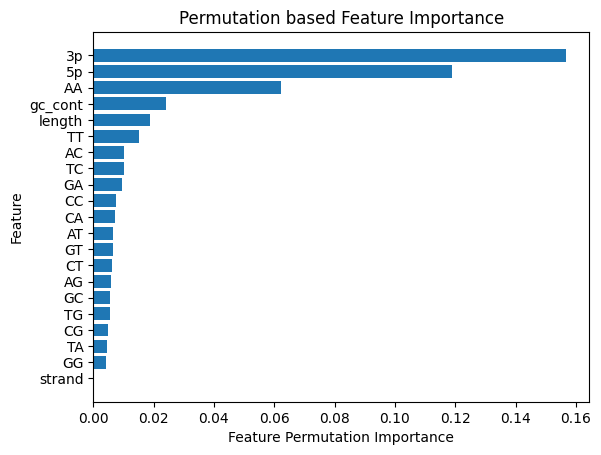

In [12]:
plt.rcParams.update({'font.size': 10})
fig4=plt.figure()
plt.barh(Xdt_train.columns[top_fidx3], perm_importance_t3.importances_mean[top_fidx3])
plt.xlabel("Feature Permutation Importance")
plt.ylabel('Feature')
plt.title('Permutation based Feature Importance')
fig4.savefig("Permutation_based_FI_dinuc_URFFG_v1.pdf")